# **Caso de Analítica - NLP Twitter**

## Introducción

En este Caso 2 debes realizar un análisis sentimental, sintáctico y gramatical de comentarios Twitter. La base de datos la puedes descargar desde eStudy (Caso 3 dataset), la cual contiene un CSV de mensajes enviados a Twitter con las siguientes columnas:

1. Puntuación sentimental o polaridad (-5 = negativa ... 0 = neutral ... 5 = positiva) (por calcular)
2. Id del tweet
3. Fecha del tweet (Sat May 16 23:58:44 UTC 2009)
4. Búsqueda. Si no hay búsqueda, el valor es NO_QUERY
5. Usuario que ha tweeteado
6. Texto del tweet

Con estos datos se os propone que apliquéis técnicas analíticas y de visualización para responder a las siguientes preguntas. No hay restricciones acerca de las técnicas ni tecnologías a utilizar siempre y cuando los resultados sean reproducibles y estén debidamente justificados. No obstante, las siguientes librerías y códigos de ejemplo os pueden ser muy útiles para responderlas:

> **_Librería NLTK:_** [https://www.nltk.org/install.html]()
>  
> **Propósito**: 
> Trabajar con datos en lenguaje humano.

> **_Librería texstat:_** [https://pypi.org/project/textstat]()
>  
> **Propósito**: 
> Calcular estadística a partir de datos en lenguaje humano.

---

### Unsupervised-Text-Clustering using Natural Language Processing (NLP)

Para realizar un conglomerado analítico de un corpus documental/textos se acostumbra a seguir los siguientes pasos genéricos. La técnica consiste en crear un vector cuantitativo a partir de los textos, previa limpieza y transformación, para aplicar técnicas de conglomerado:

1. Eliminar caracteres de puntuación, espacios adicionales, dígitos u otros caracteres que puedan entorpecer el análisis textual
2. Tokenizar y eliminar Stopwords. Se requiere un diccionario de palabras para quitar aquellas que puedan entorpecer el análisis textual. Por ejemplo, se puede utilizar **“from nltk.corpus import stopwords”. Ejemplo: NLTK stop words - Python Tutorial (pythonspot.com)**
3. Encontrar la raíz de las palabras aplicando **lemmatization o stemming**.
4. Aplicar vectorizado del tokenizado para calcular apariciones de los tokens y cuantificar los tweets. Se pueden usar distintos cálculos, por ejemplo **Bag-of-Words, Word2Vec, o TFIDF** con **“from
sklearn.feature_extraction.text import TfidfVectorizer”**
5. Aplicar clustering con técnicas adecuadas. Por ejemplo, Kmeans previo cálculo del número de clusters con técnicas como Elbow.

---

### Análisis de sentimientos en Python - Transformers
Huggingface pone a disposición una manera muy asequible de realizar análisis sentimentales con modelos pre-entrenados. 

Sigue estos dos enlaces para poder realizar las preguntas extras del caso:
1. [Getting Started with Sentiment Analysis using Python](https://huggingface.co/blog/sentiment-analysis-python) 
2. [Pipelines](https://huggingface.co/docs/transformers/main_classes/pipelines)

---


### Librerías Necesarias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import seaborn as sns
import textstat

from collections import Counter
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

from caso02.descomprimir_dataset import unzip_dataset

In [2]:
# Carga de datos
# Cargar dataset y descomprimir en /datos
csv_dataset_path = unzip_dataset()
print(csv_dataset_path)

tweets_df = pd.read_csv(csv_dataset_path)
tweets_muestra = tweets_df.sample(n=50000)
tweets_df.describe()

Folder /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-analitica-mbd/caso02/data ya existe.
Archivo de datos training.1600000.processed.noemoticon.csv ya existe
/Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-analitica-mbd/caso02/data/training.1600000.processed.noemoticon.csv


,0,1467810369
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


### Descarga de recursos necesarios de NLTK
Iniciamos la ruta dentro de "./data/nltk_data" relativa al proyecto.
Debe ser antes del import de la librería para que tenga efecto.
Por defecto, se usa en la ruta del usuario, lo que puede ser problemático en otras instalaciones y proyectos.

In [3]:
#Descarga de recursos necesarios de NLTK
os.environ["NLTK_DATA"]=os.path.abspath('./data/nltk_data')
import  nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.data.path.append(os.path.abspath('./data/nltk_data'))
nltk.download('punkt', download_dir=os.path.abspath('./data/nltk_data'))
nltk.download('stopwords', download_dir=os.path.abspath('./data/nltk_data'))
nltk.download('wordnet', download_dir=os.path.abspath('./data/nltk_data'))
nltk.download('omw-1.4', download_dir=os.path.abspath('./data/nltk_data'))
nltk.download('words', download_dir=os.path.abspath('./data/nltk_data'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-
[nltk_data]     analitica-mbd/caso02/data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-
[nltk_data]     analitica-mbd/caso02/data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-
[nltk_data]     analitica-mbd/caso02/data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-
[nltk_data]     analitica-mbd/caso02/data/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/edwinlopezariaz/UNI/ANALITICA-DATOS/casos-
[nltk_data]     analitica

True

---

## Pre-Procesamiento de los datos

#### Asignamos nombres a columnas del Dataset

In [4]:
# Otros Códigos
tweets_df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
tweets_df.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Eliminamos la Columna 'flag' debido a que no aporta información relevante

In [5]:
tweets_df = tweets_df.drop('flag', axis=1)

#### Realizamos una limpieza de los datos utilizando técnicas de conglomerado. Cada paso está numerado en su respectiva función, como se muestra a continuación:
1. Eliminar caracteres de puntuación, espacios adicionales, dígitos u otros caracteres que puedan entorpecer
el análisis textual
2. Tokenizar y eliminar Stopwords. Se requiere un diccionario de palabras para quitar aquellas que puedan
entorpecer el análisis textual. Por ejemplo, se puede utilizar “from nltk.corpus import stopwords”. Ejemplo:
NLTK stop words - Python Tutorial (pythonspot.com)
3. Encontrar la raíz de las palabras aplicando lemmatization o stemming.
4. Aplicar vectorizado del tokenizado para calcular apariciones de los tokens y cuantificar los tweets. Se
pueden usar distintos cálculos, por ejemplo Bag-of-Words, Word2Vec, o TFIDF con “from
sklearn.feature_extraction.text import TfidfVectorizer”
5. Aplicar clustering con técnicas adecuadas. Por ejemplo, Kmeans previo cálculo del número de clusters con
técnicas como Elbow.

In [6]:
#1.
def limpieza_datos(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^\w\s@]', '', text)  # Mantener los @
    text = text.strip() 
    return text

#Aplicamos la funcion Limpieza de Datos en el Dataset
tweets_df['text'] = tweets_df['text'].apply(limpieza_datos)

#Printamos los Datos para visualizar la limpieza
tweets_df.head(100)

,target,ids,date,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by t...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,kenichan i dived many times for the ball manag...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,nationwideclass no its not behaving at all im ...
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,kwesidei not the whole crew
...,...,...,...,...,...
95,0,1467836500,Mon Apr 06 22:26:28 PDT 2009,natalieantipas,so ryleegracewana go steves party or not sadly...
96,0,1467836576,Mon Apr 06 22:26:29 PDT 2009,timdonnelly,hey i actually won one of my bracket pools too...
97,0,1467836583,Mon Apr 06 22:26:29 PDT 2009,homeworld,stark you dont follow me either and i work for...
98,0,1467836859,Mon Apr 06 22:26:33 PDT 2009,willy_chaz,a bad nite for the favorite teams astros and s...


In [7]:
#2.
stop_words = set(stopwords.words('english'))
def tokenizar_y_eliminar_stopwords(text):
    tokens = word_tokenize(text)
    tokens_filtrados = [word for word in tokens if word not in stop_words]
    return tokens_filtrados

#Aplicamos la función sobre el dataset
tweets_df['tokens'] = tweets_df['text'].apply(tokenizar_y_eliminar_stopwords)

In [8]:
#3.
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

#Aplicamos la función sobre el dataset
tweets_df['lemmatized_tokens'] = tweets_df['tokens'].apply(lemmatize_tokens)

In [9]:
#4.
tweets_df['processed_text'] = tweets_df['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(tweets_df['processed_text'])

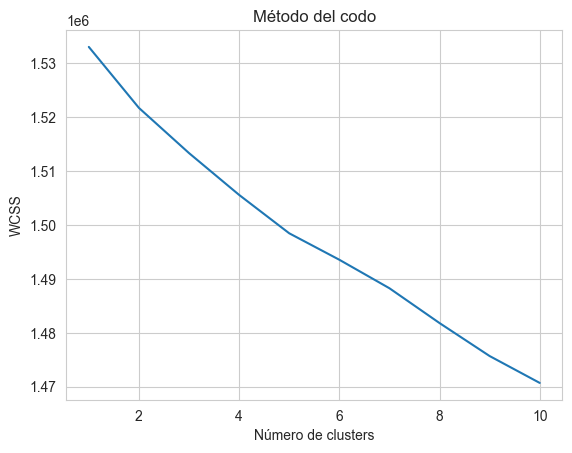

,target,ids,date,user,text,tokens,lemmatized_tokens,processed_text,cluster
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by t...,"[upset, cant, update, facebook, texting, might...","[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...,0
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,kenichan i dived many times for the ball manag...,"[kenichan, dived, many, times, ball, managed, ...","[kenichan, dived, many, time, ball, managed, s...",kenichan dived many time ball managed save res...,0
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]","[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire,0
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,nationwideclass no its not behaving at all im ...,"[nationwideclass, behaving, im, mad, cant, see]","[nationwideclass, behaving, im, mad, cant, see]",nationwideclass behaving im mad cant see,1
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,kwesidei not the whole crew,"[kwesidei, whole, crew]","[kwesidei, whole, crew]",kwesidei whole crew,0


In [10]:
#5.
def metodo_elbow(X):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Método del codo')
    plt.xlabel('Número de clusters')
    plt.ylabel('WCSS')
    plt.show()

metodo_elbow(X)
kmeans = KMeans(n_clusters=3, max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X)
tweets_df['cluster'] = clusters
tweets_df.head()

---

## Análisis

### 1. ¿Cuál es la distribución de las polaridades y complejidad de lectura/escritura de los tweets en el dataset?

#### 1.a. ¿Hay una mayor cantidad de tweets positivos, negativos o neutrales?

#### 1.b. ¿Cómo se relacionan las distintas polaridades según la complejidad de lectura/escritura de los tweets?

(-5.011, -4.0]     16603
(-4.0, -3.0]       32050
(-3.0, -2.0]       78590
(-2.0, -1.0]       92760
(-1.0, 0.0]       692924
(0.0, 1.0]        225595
(1.0, 2.0]        197012
(2.0, 3.0]        149083
(3.0, 4.0]         95101
(4.0, 5.0]         20281
Name: count, dtype: int64


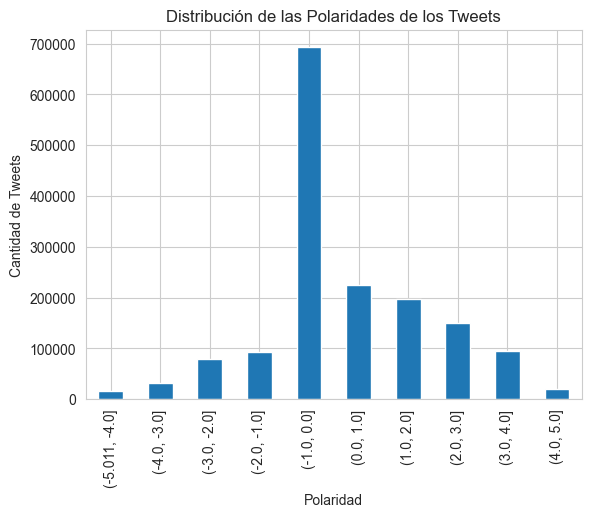

In [11]:
#1.a

def calcular_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity * 5

tweets_df['polarity'] = tweets_df['text'].apply(calcular_polarity)

polarity_counts = tweets_df['polarity'].value_counts(bins=10, sort=False)
print(polarity_counts)

polarity_counts.plot(kind='bar', title='Distribución de las Polaridades de los Tweets')
plt.xlabel('Polaridad')
plt.ylabel('Cantidad de Tweets')
plt.show()

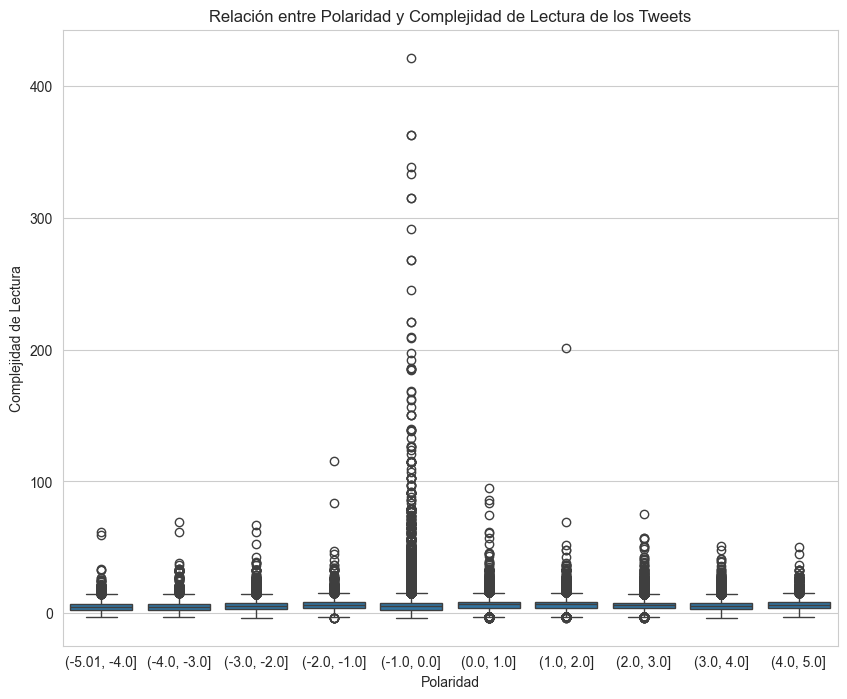

,target,ids,date,user,text,tokens,lemmatized_tokens,processed_text,cluster,polarity,readability
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his facebook by t...,"[upset, cant, update, facebook, texting, might...","[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...,0,0.000000,7.9
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,kenichan i dived many times for the ball manag...,"[kenichan, dived, many, times, ball, managed, ...","[kenichan, dived, many, time, ball, managed, s...",kenichan dived many time ball managed save res...,0,2.500000,4.0
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]","[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire,0,1.000000,0.1
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,nationwideclass no its not behaving at all im ...,"[nationwideclass, behaving, im, mad, cant, see]","[nationwideclass, behaving, im, mad, cant, see]",nationwideclass behaving im mad cant see,1,-3.125000,7.9
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,kwesidei not the whole crew,"[kwesidei, whole, crew]","[kwesidei, whole, crew]",kwesidei whole crew,0,1.000000,-1.9
...,...,...,...,...,...,...,...,...,...,...,...
95,0,1467836500,Mon Apr 06 22:26:28 PDT 2009,natalieantipas,so ryleegracewana go steves party or not sadly...,"[ryleegracewana, go, steves, party, sadly, sin...","[ryleegracewana, go, steves, party, sadly, sin...",ryleegracewana go steves party sadly since eas...,0,1.583333,7.6
96,0,1467836576,Mon Apr 06 22:26:29 PDT 2009,timdonnelly,hey i actually won one of my bracket pools too...,"[hey, actually, one, bracket, pools, bad, wasn...","[hey, actually, one, bracket, pool, bad, wasnt...",hey actually one bracket pool bad wasnt one money,0,-1.750000,7.6
97,0,1467836583,Mon Apr 06 22:26:29 PDT 2009,homeworld,stark you dont follow me either and i work for...,"[stark, dont, follow, either, work]","[stark, dont, follow, either, work]",stark dont follow either work,0,-1.000000,2.9
98,0,1467836859,Mon Apr 06 22:26:33 PDT 2009,willy_chaz,a bad nite for the favorite teams astros and s...,"[bad, nite, favorite, teams, astros, spartans,...","[bad, nite, favorite, team, astros, spartan, l...",bad nite favorite team astros spartan lose nit...,0,0.833333,5.6


In [12]:
#1.b

def calcular_readability(text):
    return textstat.flesch_kincaid_grade(text)

tweets_df['readability'] = tweets_df['text'].apply(calcular_readability)

plt.figure(figsize=(10, 8))
sns.boxplot(x=pd.cut(tweets_df['polarity'], bins=10), y='readability', data=tweets_df)
plt.title('Relación entre Polaridad y Complejidad de Lectura de los Tweets')
plt.xlabel('Polaridad')
plt.ylabel('Complejidad de Lectura')
plt.show()

tweets_df.head(100)

### 2. ¿Existen patrones gramaticales o sintácticos comunes en los tweets con polaridad positiva o negativa? Por ejemplo, puede que los tweets positivos tiendan a utilizar más palabras de agradecimiento o elogios, mientras que los tweets negativos utilizan más palabras de crítica o enojo.

In [13]:
#2.
tweets_positivos = tweets_df[tweets_df['polarity'] > 0]
tweets_negativos = tweets_df[tweets_df['polarity'] < 0]

frecuencia_palabras_positivas = Counter([word for tokens in tweets_positivos['lemmatized_tokens'] for word in tokens])

frecuencia_palabras_negativas = Counter([word for tokens in tweets_negativos['lemmatized_tokens'] for word in tokens])

palabras_comunes_positivas = frecuencia_palabras_positivas.most_common(20)
palabras_comunes_negativas = frecuencia_palabras_negativas.most_common(20)

df_palabras_positivas = pd.DataFrame(palabras_comunes_positivas, columns=['Palabra', 'Frecuencia'])
df_palabras_negativas = pd.DataFrame(palabras_comunes_negativas, columns=['Palabra', 'Frecuencia'])

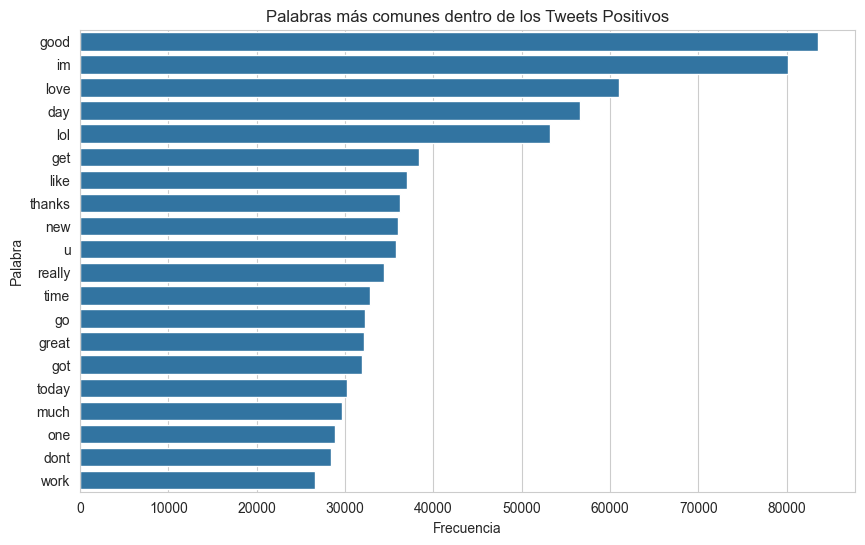

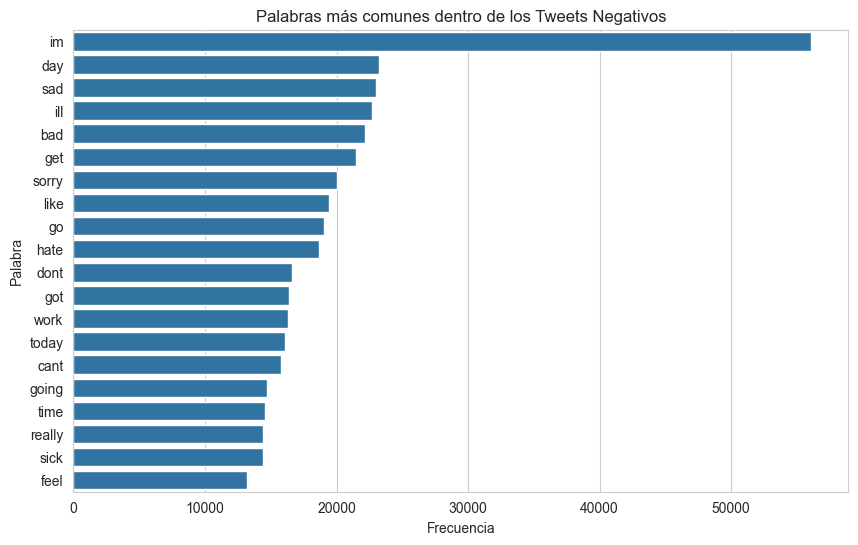

In [14]:
#Graficamos las palabras más comunes en tweets positivos
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_palabras_positivas)
plt.title('Palabras más comunes dentro de los Tweets Positivos')
plt.show()

#Graficamos las palabras más comunes en tweets negativos
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_palabras_negativas)
plt.title('Palabras más comunes dentro de los Tweets Negativos')
plt.show()

### 3.  ¿Qué usuarios tienden a generar tweets con una polaridad más positiva o negativa? ¿Hay alguna relación entre la polaridad de los tweets y el número de seguidores de un usuario?

In [15]:
tweets_muestra.columns = ['id', 'polarity', 'timestamp', 'query', 'user', 'text']
tweets_muestra['followers_count'] = tweets_muestra['text'].str.count('@')
print(tweets_muestra.head())

         id    polarity                     timestamp     query         user  \
1392791   4  2053445401  Sat Jun 06 04:34:51 PDT 2009  NO_QUERY    ssannddra   
148747    0  1883222790  Fri May 22 08:12:20 PDT 2009  NO_QUERY  samtibbitts   
21289     0  1557251724  Sun Apr 19 02:56:16 PDT 2009  NO_QUERY      minxuan   
76031     0  1695438959  Mon May 04 06:08:19 PDT 2009  NO_QUERY      ccmehil   
473505    0  2177103854  Mon Jun 15 05:27:25 PDT 2009  NO_QUERY    megs11432   

                                                      text  followers_count  
1392791    @nnamibbia you're wecome! I hope see you today                 1  
148747   everytime i go to check weather.com i keep put...                0  
21289    CRISIS! Massive flood in house - from toilet b...                0  
76031    and when you think about things like that with...                0  
473505   dammit  to hell, I never got rob thomas ticket...                0  


In [16]:
#Calcular la polaridad promedio por usuario
polaridad_promedio_por_usuario = tweets_muestra.groupby('user')['polarity'].mean()
polaridad_promedio_por_usuario = polaridad_promedio_por_usuario.sort_values()

print("Usuarios con la polaridad más positiva:")
print(polaridad_promedio_por_usuario.tail())

print("\nUsuarios con la polaridad más negativa:")
print(polaridad_promedio_por_usuario.head())

Usuarios con la polaridad más positiva:
user
maryag         2.329170e+09
sushieemee     2.329175e+09
annakarenx     2.329198e+09
alyssa_f17     2.329203e+09
Pauline1951    2.329204e+09
Name: polarity, dtype: float64

Usuarios con la polaridad más negativa:
user
joy_wolf        1.467811e+09
Missy_BB        1.467824e+09
weefranniev     1.467841e+09
angelaleeds     1.467842e+09
sprocket2cog    1.467843e+09
Name: polarity, dtype: float64


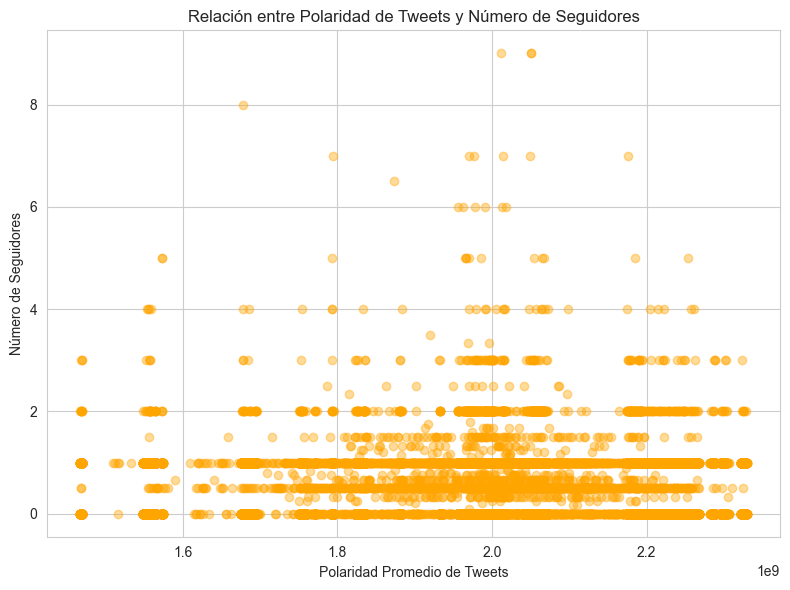

In [17]:
#Calculamos la correlación entre la polaridad promedio y el número de seguidores
correlacion = tweets_muestra.groupby('user').agg({'polarity': 'mean', 'followers_count': 'mean'})

#Se grafica el diagrama de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(correlacion['polarity'], correlacion['followers_count'], color='orange', alpha=0.4)
plt.title('Relación entre Polaridad de Tweets y Número de Seguidores')
plt.xlabel('Polaridad Promedio de Tweets')
plt.ylabel('Número de Seguidores')
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretación de Resultados:

- El resultado de la gráfica de dispersión nos indica que la polaridad de los tweets (si son más positivos o negativos) no tiene un impacto directo en la cantidad de seguidores que un usuario puede tener en este conjunto de datos.

- Otros factores como la relevancia del contenido, la interacción con otros usuarios, la frecuencia de publicación y la popularidad previa pueden influir más en el número de seguidores de un usuario en esta muestra.

### 4. ¿Hay alguna palabra o conjunto de palabras específicas que estén asociadas con tweets de polaridad extrema?

#### 4.a. ¿Estas palabras son más comunes en tweets sobre un tema en particular o están distribuidas en todo el dataset?

#### 4.b. Escoge un tema y clusteriza los usuarios según polaridades.

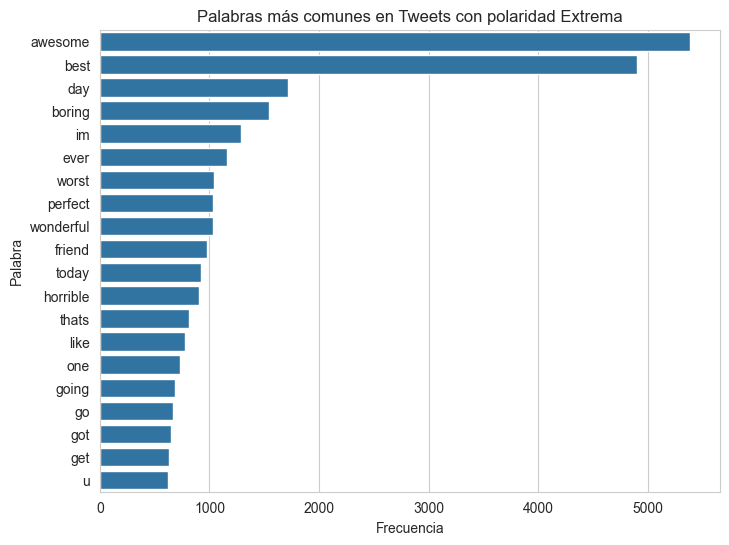

In [18]:
#4.a
tweets_extremos = tweets_df[(tweets_df['polarity'] == 5) | (tweets_df['polarity'] == -5)]

#Se identifican las frecuencias de palabras en los tweets con polaridad extrema
frecuencia_palabras_extremas = Counter([word for tokens in tweets_extremos['lemmatized_tokens'] for word in tokens])
palabras_comunes_extremas = frecuencia_palabras_extremas.most_common(20)

df_palabras_extremas = pd.DataFrame(palabras_comunes_extremas, columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_palabras_extremas)
plt.title('Palabras más comunes en Tweets con polaridad Extrema')
plt.show()

### Se aplicó el algoritmo KMeans para agrupar a los usuarios en clusters y se visualizó la distribución de usuarios en función de la polaridad de sus publicaciones y la complejidad de lectura mediante un ScatterPlot.

/var/folders/fs/v56gcgbd31z4cyt1j9fvrcdr0000gq/T/ipykernel_8959/3855869021.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usuarios_love['cluster'] = kmeans.fit_predict(X_love)


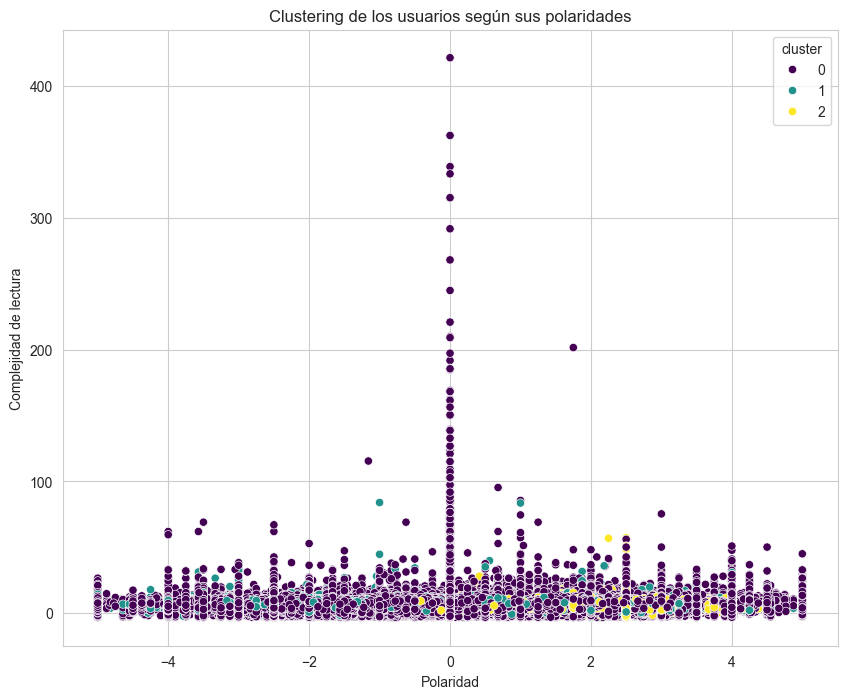

,user,polarity,cluster
0,scotthamilton,0.000000,0
1,mattycus,2.500000,0
2,ElleCTF,1.000000,0
3,Karoli,-3.125000,1
4,joy_wolf,1.000000,0
5,mybirch,0.000000,0
6,coZZ,1.366667,1
7,2Hood4Hollywood,0.000000,0
8,mimismo,0.000000,0
9,erinx3leannexo,-1.071429,0


In [19]:
#4.b
tweets_df['tema_love'] = tweets_df['processed_text'].apply(lambda text: 1 if 'love' in text else 0)
usuarios_love = tweets_df[tweets_df['tema_love'] == 1]

# Vectorizamos los tweets sobre 'love'
X_love = vectorizer.fit_transform(usuarios_love['processed_text'])

# Clustering con KMeans 
kmeans = KMeans(n_clusters=3, random_state=0)
usuarios_love['cluster'] = kmeans.fit_predict(X_love)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='polarity', y='readability', hue='cluster', data=tweets_df, palette='viridis')
plt.title('Clustering de los usuarios según sus polaridades')
plt.xlabel('Polaridad')
plt.ylabel('Complejidad de lectura')
plt.show()

tweets_df[['user', 'polarity', 'cluster']].head(50)

### 5. ¿Hay alguna correlación entre la polaridad de un tweet y la fecha en que se publicó?

#### 5.a. ¿Los tweets publicados durante ciertos períodos de tiempo tienden a ser más positivos o negativos que otros?

/var/folders/fs/v56gcgbd31z4cyt1j9fvrcdr0000gq/T/ipykernel_8959/2483477228.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:49 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets_df['date'] = pd.to_datetime(tweets_df['date'])


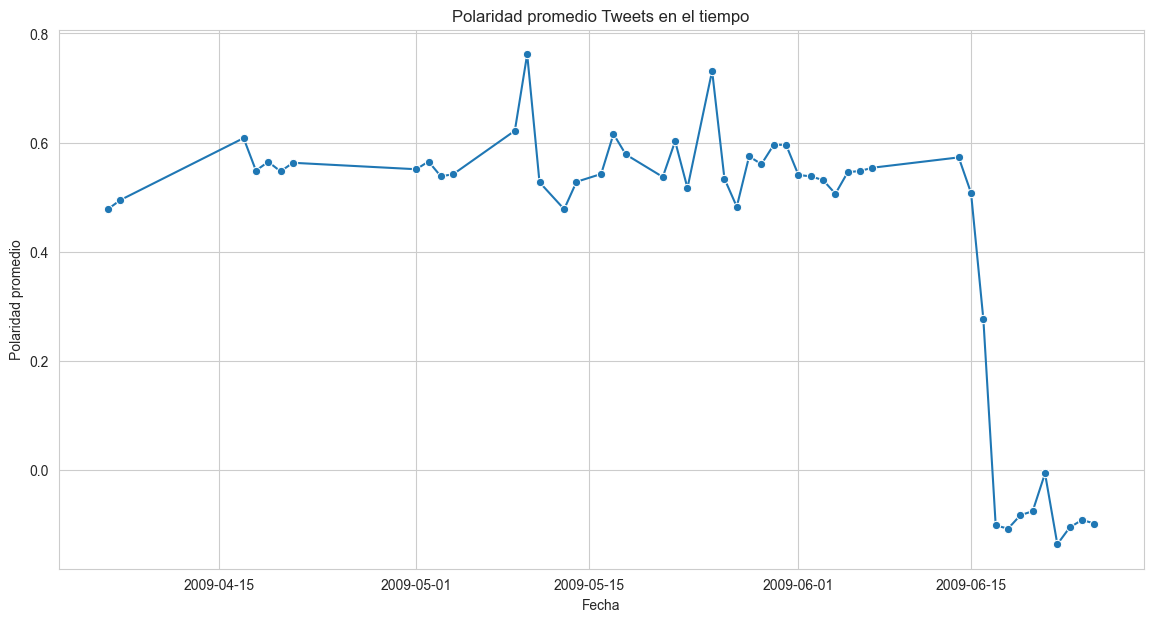

In [20]:
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

#Agrupamos fechas por día y calculamos la polaridad promedio
polaridad_total = tweets_df.resample('D', on='date')['polarity'].mean().reset_index()

#Se grafica la polaridad promedio a lo largo del tiempo para una análisis general 
plt.figure(figsize=(14, 7))
sns.lineplot(data=polaridad_total, x='date', y='polarity', marker='o')
plt.title('Polaridad promedio Tweets en el tiempo')
plt.xlabel('Fecha')
plt.ylabel('Polaridad promedio')
plt.show()

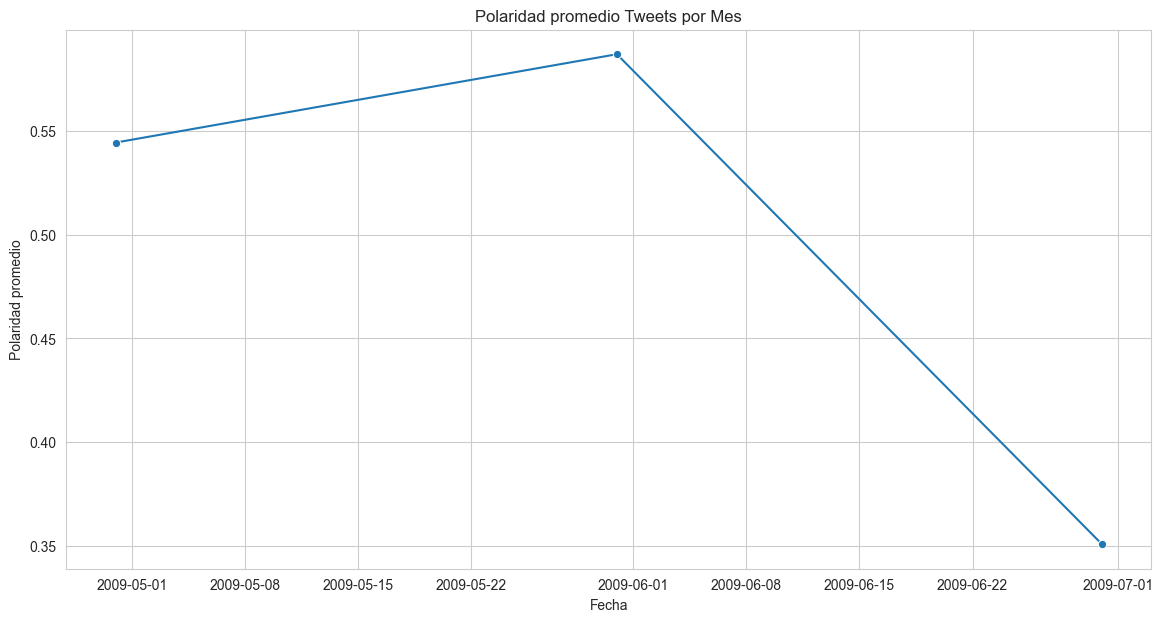

In [22]:
#Agrupamos por mes y se calcula la polaridad promedio
polaridad_mensual = tweets_df.resample('ME', on='date')['polarity'].mean().reset_index()

#Se grafica la polaridad promedio mes a mes para análisis exhaustivo
plt.figure(figsize=(14, 7))
sns.lineplot(data=polaridad_mensual, x='date', y='polarity', marker='o')
plt.title('Polaridad promedio Tweets por Mes')
plt.xlabel('Fecha')
plt.ylabel('Polaridad promedio')
plt.show()

### 6. Identifica los "Top 10 Trolls" y los "Top 10 Influencers". Justifica las características de un usuario Troll e Influencer.

Para identificar a los Trolls e Influencer debemos tener en cuenta las siguientes características:
- Trolls:
    - Generan una gran cantidad de tweets con polaridad negativa.
    - Pueden tener un alto número de menciones negativas en sus tweets.

- Influencers:
    - Tienen un alto número de seguidores.
    - Generan una gran cantidad de tweets con polaridad positiva.
    - Sus tweets tienden a ser compartidos o mencionados con frecuencia en un contexto positivo. 

In [23]:
#Calculamos la polaridad promedio por usuario
polaridad_promedio_por_usuario = tweets_muestra.groupby('user')['polarity'].mean()
seguidores_por_usuario = tweets_muestra.groupby('user')['followers_count'].max()

#Ordenamos los usuarios por polaridad promedio y número de seguidores
polaridad_promedio_por_usuario = polaridad_promedio_por_usuario.sort_values(ascending=False)
seguidores_por_usuario = seguidores_por_usuario.loc[polaridad_promedio_por_usuario.index]

#Top 10 Influencers por número de seguidores
top_influencers = seguidores_por_usuario.head(10)

#Top 10 Trolls por polaridad promedio
top_trolls = polaridad_promedio_por_usuario.head(10)

# Mostrar los resultados
print("Top 10 Influencers:")
print(top_influencers)

print("\nTop 10 Trolls:")
print(top_trolls)

Top 10 Influencers:
user
Pauline1951        1
alyssa_f17         0
annakarenx         1
sushieemee         0
maryag             1
johnrkd            0
jester1436         0
Kristinrodrigue    1
trickysticky       0
raanve             1
Name: followers_count, dtype: int64

Top 10 Trolls:
user
Pauline1951        2.329204e+09
alyssa_f17         2.329203e+09
annakarenx         2.329198e+09
sushieemee         2.329175e+09
maryag             2.329170e+09
johnrkd            2.329140e+09
jester1436         2.329140e+09
Kristinrodrigue    2.329091e+09
trickysticky       2.329064e+09
raanve             2.329061e+09
Name: polarity, dtype: float64


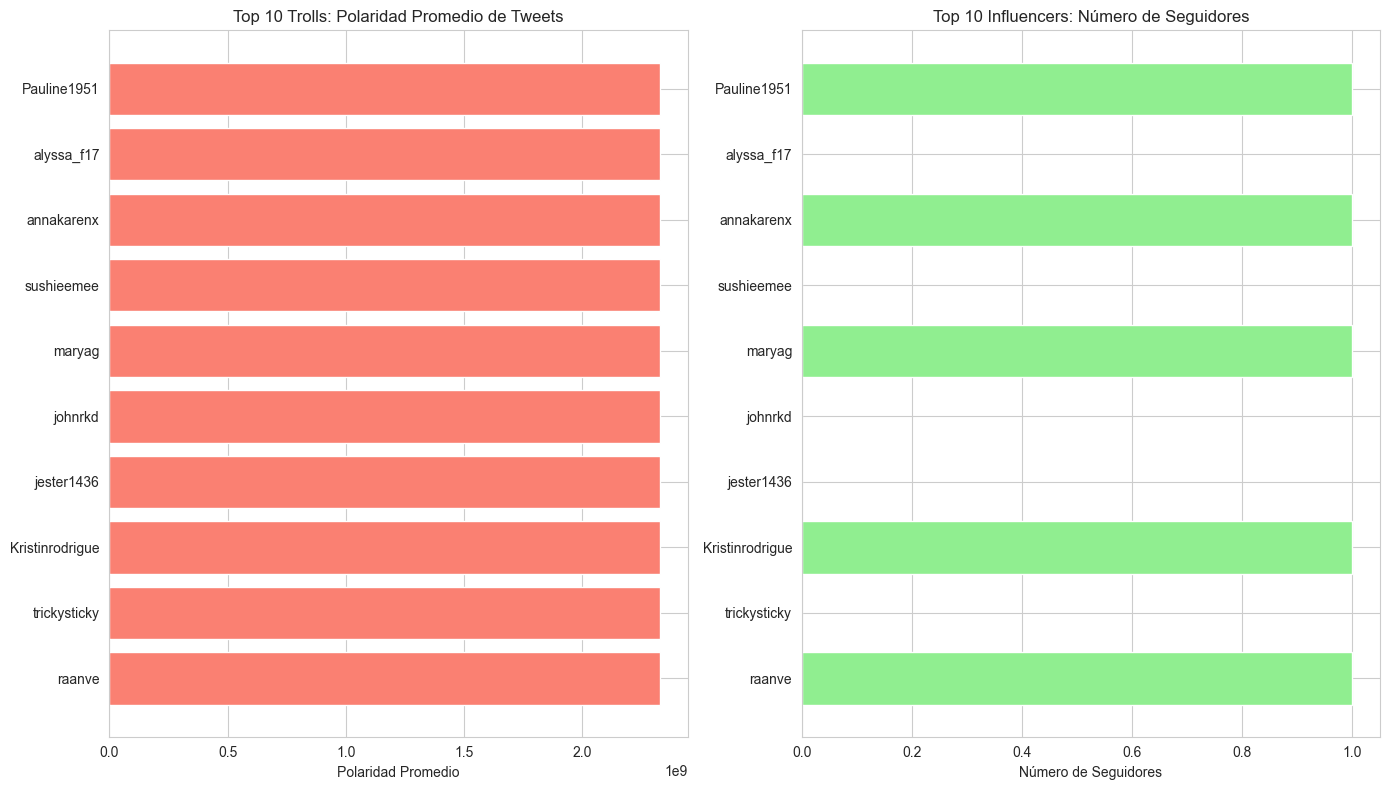

In [24]:
top_trolls = polaridad_promedio_por_usuario.head(10)
top_influencers = seguidores_por_usuario.head(10)

#Graficamos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

#Top 10 Trolls
ax1.barh(top_trolls.index, top_trolls.values, color='salmon')
ax1.set_xlabel('Polaridad Promedio')
ax1.set_title('Top 10 Trolls: Polaridad Promedio de Tweets')
ax1.invert_yaxis()

#Top 10 Influencers
ax2.barh(top_influencers.index, top_influencers.values, color='lightgreen')
ax2.set_xlabel('Número de Seguidores')
ax2.set_title('Top 10 Influencers: Número de Seguidores')
ax2.invert_yaxis()
plt.tight_layout()
plt.show()

### 7. Extra: Utiliza Transformers con el pipeline de Huggingface para calcular la polaridad de los tweets y comparar los resultados de la pregunta 1.

In [31]:
# Respuesta
from transformers import pipeline

# Creamos un analisis de sentimientos usando el pipeline
nlp = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")
resultados_analisis_sentimientos = nlp(tweets_df['text'].tolist())



# Display the DataFrame with sentiment analysis results
#tweets_df.head()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


KeyboardInterrupt: 

---

## Visualización

### 1. ¿Cómo se distribuyen los tweets según su polaridad a lo largo del tiempo?

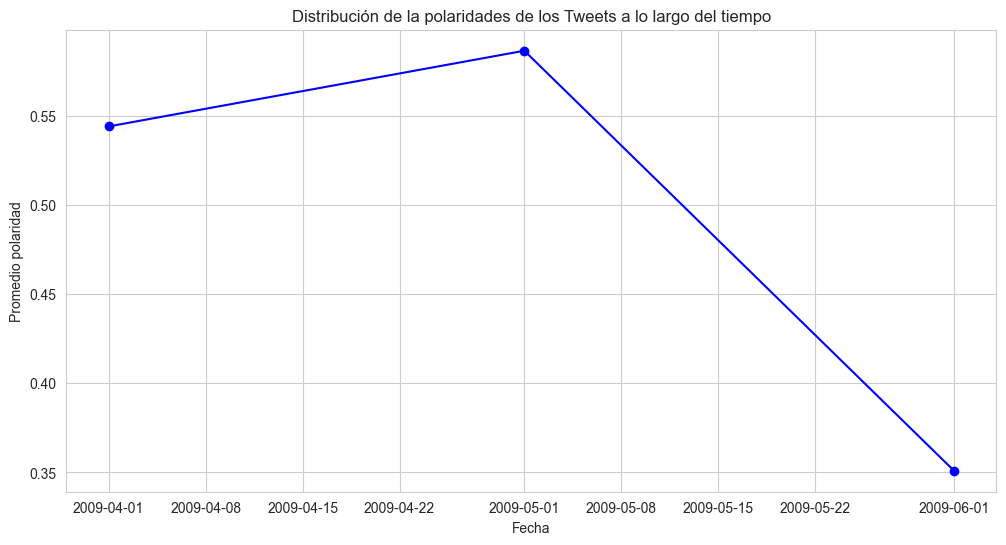

In [40]:
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df['month'] = tweets_df['date'].dt.to_period('M')
polaridad_mensual = tweets_df.groupby('month')['polarity'].mean().reset_index()
polaridad_mensual['month'] = polaridad_mensual['month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(polaridad_mensual['month'], polaridad_mensual['polarity'], marker='o', linestyle='-', color='b')
plt.title('Distribución de la polaridades de los Tweets a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Promedio polaridad')
plt.grid(True)
plt.show()

### 2. Visualiza el análisis sintáctico (número de palabras, frase, verbos, nombres...) de los top 10 Trolls e Influencers.

In [ ]:
# Respuesta
print("Respuestas")

### 3. ¿Existe alguna correlación entre el número de seguidores de un usuario y la polaridad de sus tweets? Representa visualmente esta relación.

In [33]:
polaridad_promedio_por_usuario = tweets_muestra.groupby('user')['polarity'].mean()
seguidores_por_usuario = tweets_muestra.groupby('user')['followers_count'].max()

df_correlacion = pd.DataFrame({'polarity': polaridad_promedio_por_usuario, 'followers_count': seguidores_por_usuario})
correlacion = df_correlacion.corr()

coeficiente_correlacion = correlacion.loc['polarity', 'followers_count']
print(f"Coeficiente de correlación: {coeficiente_correlacion}")

Coeficiente de correlación: -0.03751044060807853


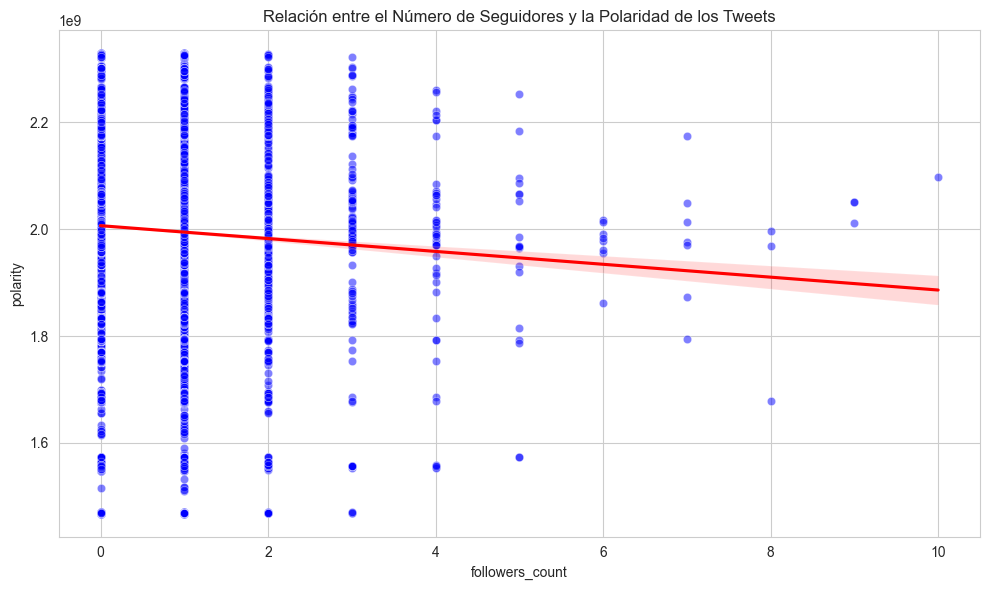

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_correlacion, x='followers_count', y='polarity', color='blue', alpha=0.5)

plt.xlabel('Número de Seguidores')
plt.ylabel('Polaridad Promedio de los Tweets')
plt.title('Relación entre el Número de Seguidores y la Polaridad de los Tweets')

sns.regplot(data=df_correlacion, x='followers_count', y='polarity', scatter=False, color='red')

plt.grid(True)
plt.tight_layout()
plt.show()


### 4. Crea una nube de palabras para cada polaridad.

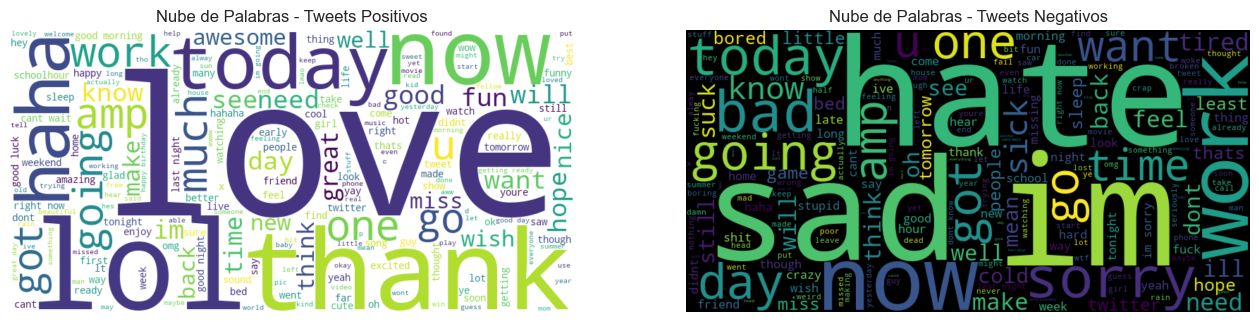

In [35]:
tweets_positivos = tweets_df[tweets_df['polarity'] > 0]
tweets_negativos = tweets_df[tweets_df['polarity'] < 0]

texto_positivos = ' '.join(tweets_positivos['text'])
texto_negativos = ' '.join(tweets_negativos['text'])

wordcloud_positivos = WordCloud(width=800, height=400, background_color='white').generate(texto_positivos)
wordcloud_negativos = WordCloud(width=800, height=400, background_color='black').generate(texto_negativos)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positivos, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets Positivos')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negativos, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets Negativos')
plt.axis('off')

plt.show()

### 5. ¿Cómo se distribuyen los tweets según su polaridad en función de la hora del día o el día de la semana?

In [36]:
#Convertir la columna timestamp a formato datetime
tweets_muestra['timestamp'] = pd.to_datetime(tweets_muestra['timestamp'])
tweets_muestra['hour_of_day'] = tweets_muestra['timestamp'].dt.hour
tweets_muestra['day_of_week'] = tweets_muestra['timestamp'].dt.day_name()

polaridad_por_hora = tweets_muestra.groupby('hour_of_day')['polarity'].mean()

#Calculamos la polaridad promedio por día de la semana
polaridad_por_dia_semana = tweets_muestra.groupby('day_of_week')['polarity'].mean()




/var/folders/fs/v56gcgbd31z4cyt1j9fvrcdr0000gq/T/ipykernel_8959/1832584176.py:2: FutureWarning: Parsed string "Sat Jun 06 04:34:51 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets_muestra['timestamp'] = pd.to_datetime(tweets_muestra['timestamp'])


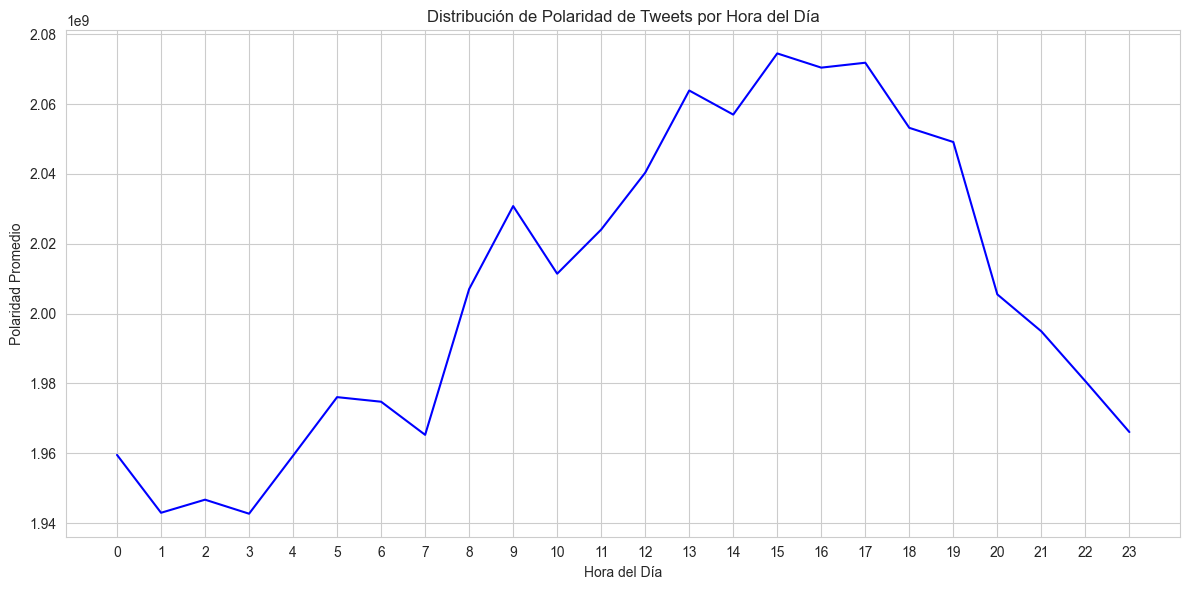

In [37]:
#Graficamos la distribución de polaridad por hora del día
plt.figure(figsize=(12, 6))
sns.lineplot(x=polaridad_por_hora.index, y=polaridad_por_hora.values, color='blue')
plt.title('Distribución de Polaridad de Tweets por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Polaridad Promedio')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/fs/v56gcgbd31z4cyt1j9fvrcdr0000gq/T/ipykernel_8959/3066121862.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=polaridad_por_dia_semana.index, y=polaridad_por_dia_semana.values, palette='viridis')


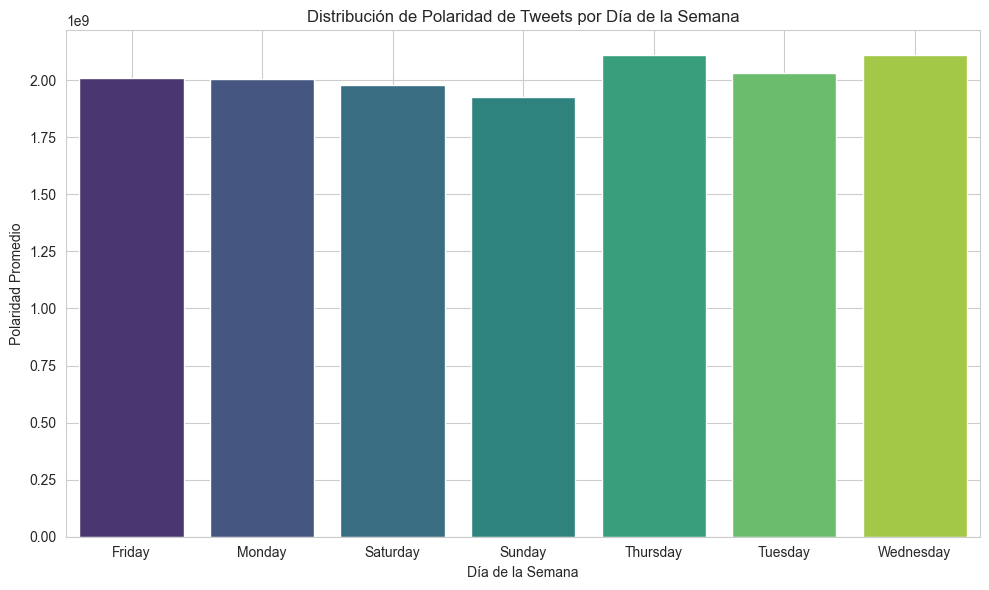

In [38]:
#Graficamos la distribución de polaridad por día de la semana
plt.figure(figsize=(10, 6))
sns.barplot(x=polaridad_por_dia_semana.index, y=polaridad_por_dia_semana.values, palette='viridis')
plt.title('Distribución de Polaridad de Tweets por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Polaridad Promedio')
plt.grid(True)
plt.tight_layout()
plt.show()